In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

c:\Users\firda\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
dataset_path = r'C:\Users\firda\OneDrive\Študijný materiál\VŠ\2024 LS 2.rocnik\NeuronoveSiete\Zadanie\modely\included_2016_nn_dataset_input.xlsx'
aglo_data = pd.read_excel(dataset_path, sheet_name="Sheet1")

In [4]:
aglo_data = aglo_data.drop(columns=["Datum do", 'Datum od'])

In [5]:
aglo_data

,Sinter.MB4.AUTO.MixingDrumNo4.AutomaticControl,Sinter.MB4.MS.Scales.Flow.Total.t/hr,Sinter.MB4.P1N.MixingDrumNo4.Permeability.kPa,Sinter.MB4.T1.MixingDrumNo4.Temperature.C,Sinter.MB4.WK1.MixingDrumNo4.Humidity.%,Sinter.SP4.FuelChange.%,Sinter.SP4.PS1.WindBoxNo1.Vacuum.kPa,Sinter.SP4.PS2.WindBoxNo2.Vacuum.kPa,Sinter.SP4.TKZH.IgnitionHood.Temperature.C,Sinter.SP4.TS21.WindBoxNo21.Temperature.C,Sinter.SP4.TS22.WindBoxNo22.Temperature.C,Sinter.SP4.TS23.WindBoxNo23.Temperature.C,Sinter.SP4.VOPB.FeedingDrum.Speed.ot/min,Sinter.SP4.VSP.SinterStrand.Speed.m/min,Sinter.TEX7.OTAC.Fan7.RPM,Sinter.TEX8.OTAC.Fan8.RPM,Sinter.SP.P2.Content.Average,Sinter.SP4.Rozsev.Under5mm.%
0,1.000000,238.398617,4.998225,49.010417,7.603067,3.115756,-6.443675,-6.313600,1137.525280,121.195484,145.385350,131.821325,0.769775,1.657650,1440.023753,1440.015502,1.32,7.770000
1,1.000000,161.446752,5.255767,46.841634,6.375500,3.150000,-6.437325,-6.307567,1197.067035,122.871392,145.677275,120.958925,0.649475,1.350908,1450.023753,1450.012007,1.42,8.820000
2,1.000000,234.273259,6.315875,52.250141,6.492567,3.230000,-6.489325,-6.283558,1099.253554,151.232716,170.338533,155.955758,0.901283,1.870042,1440.035008,1440.016251,1.53,8.880000
3,0.327217,247.792258,6.455150,53.303817,6.863133,3.230000,-7.101233,-6.901692,1149.917252,124.205216,152.734609,132.252184,0.910233,1.888308,1440.026501,1440.023008,1.55,29.889999
4,1.000000,190.335151,6.121675,52.804117,8.057417,3.100000,-5.284417,-5.071792,1106.666060,147.682458,171.863075,162.367182,0.659275,1.409475,1319.559744,1319.525996,1.48,10.220000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2883,0.864992,148.021409,6.336033,57.687033,5.577283,3.140000,-2.165392,-2.394042,1215.440404,220.582983,216.004533,175.544592,0.576600,1.263183,1350.022261,0.000000,1.28,10.810000
2884,0.000000,187.805116,6.074675,45.309408,4.704733,3.140000,-4.015708,-4.390467,1141.820040,264.763132,247.731651,211.297510,0.818842,1.659392,1249.981746,1249.974502,1.21,9.090000
2885,0.983333,233.455712,6.813817,58.953609,5.447858,3.260000,-5.767975,-5.666058,1117.415073,148.797941,141.923984,125.501067,1.088992,2.004542,1280.015740,1280.008246,1.29,7.350000
2886,0.523317,207.897550,6.355017,56.115983,4.425650,3.460000,-4.356258,-4.760308,1168.576833,220.299274,205.653708,178.486017,0.881808,1.645750,1278.392489,1278.374497,1.36,10.250000


In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(aglo_data)
data_numeric = aglo_data

In [7]:
#data_numeric = aglo_data.apply(pd.to_numeric, errors='coerce').dropna()

X = data_numeric.drop(columns=["Sinter.SP4.Rozsev.Under5mm.%"])
y = data_numeric["Sinter.SP4.Rozsev.Under5mm.%"]

scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=1234, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1234, shuffle=True)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32) 
y_val = torch.tensor(y_val, dtype=torch.float32) 
y_test = torch.tensor(y_test, dtype=torch.float32)

train = TensorDataset(X_train, y_train)
test = TensorDataset(X_test, y_test)
val = TensorDataset(X_val, y_val)

# Vytvorenie dataloaders pre trénovaciu a testovaciu sadu
train_loader = DataLoader(train, batch_size=64, shuffle=False)
test_loader = DataLoader(test, batch_size=64, shuffle=False)
validation_loader = DataLoader(val, batch_size=64, shuffle=False)

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, dropout):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim 
        self.layer_dim = layer_dim 
        self.dropout = dropout 
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, dropout = dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 64)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 16)  
        self.fc3 = nn.Linear(16, 1)  
        self.dropoutl = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

         # Forward propagation through LSTM layer
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.dropoutl(out)

        out = nn.functional.relu(self.fc(out[:, -1, :]))
        out = self.dropoutl(out)
        out = self.fc1(out)
        out = self.dropoutl(out)
        out = self.fc2(out)
        out = self.dropoutl(out)
        out = self.fc3(out)
        return out

In [9]:
num_epochs = 900
input_dim = len(X.columns) 
hidden_dim = 150
layer_dim = 3

model = LSTMModel(input_dim, hidden_dim, layer_dim, dropout=0.1)

error = nn.MSELoss()
learning_rate = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
loss_list = []
iteration_list = []
validation_loss_list = [] 
iterations = 0
for epoch in range(num_epochs):
    model.train() 
    for i, (data, labels) in enumerate(train_loader):
       
        data = data.view(-1, 1, input_dim).requires_grad_()
        
        optimizer.zero_grad()
        
        outputs = model(data)
        
        loss = error(outputs.squeeze(), labels)
        
        loss.backward()
        
        optimizer.step()
        iterations += 1

        
        if iterations % 100 == 0:
            loss_list.append(loss.item())
            iteration_list.append(iterations)

            # Výpis straty
            print('Iteration: {}. Loss: {}'.format(iterations, loss.item()))

            model.eval()  
            validation_loss = 0.0
            for data_val, labels_val in validation_loader:
                data_val = data_val.view(-1, 1, input_dim)
                outputs_val = model(data_val)
                loss_val = error(outputs_val.squeeze(), labels_val)
                validation_loss += loss_val.item() * data_val.size(0)  

            validation_loss /= len(validation_loader.dataset)  
            validation_loss_list.append(validation_loss)
            print('Validation Loss: {}'.format(validation_loss))

# po skončení všetkých epoch
plt.figure(figsize=(10, 5))
plt.plot(iteration_list, loss_list, label='Training Loss')
plt.plot(iteration_list, validation_loss_list, label='Validation Loss', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Vývoj Training a Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Iteration: 100. Loss: 14.275605201721191
Validation Loss: 13.102460246713827
Iteration: 200. Loss: 6.7430419921875
Validation Loss: 11.73536039004425
Iteration: 300. Loss: 18.400529861450195
Validation Loss: 12.490458395960149
Iteration: 400. Loss: 14.669140815734863
Validation Loss: 11.99673594943921
Iteration: 500. Loss: 17.3875789642334
Validation Loss: 11.483976071205756
Iteration: 600. Loss: 10.511988639831543
Validation Loss: 11.325292027850073
Iteration: 700. Loss: 25.437118530273438
Validation Loss: 11.039946227921625
Iteration: 800. Loss: 16.50600814819336
Validation Loss: 11.48715465228497


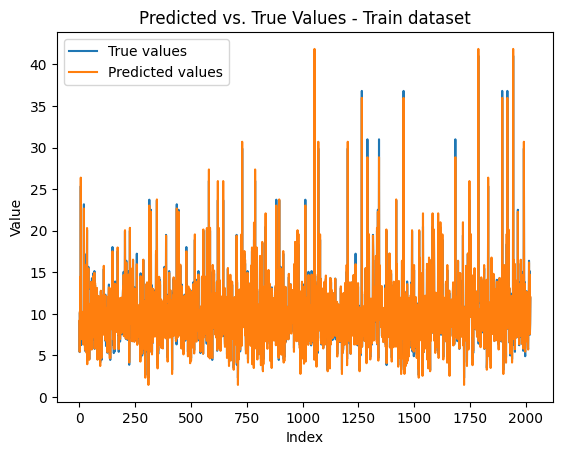

In [30]:
model.eval()

predicted_values = []
true_values = []

with torch.no_grad():
    for data, labels in train_loader:
        data = data.view(-1, 1, input_dim)
        outputs = model(data)
        predicted_values.extend(outputs.cpu().numpy())
        true_values.extend(labels.cpu().numpy())

plt.plot(true_values, label="True values")
plt.plot(predicted_values, label="Predicted values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Predicted vs. True Values - Train dataset")
plt.legend()
plt.show()

In [38]:

model.eval()

with torch.no_grad():
    for data, labels in train_loader:
        outputs = model(data.view(-1, 1, input_dim))
        
        for i in range(len(outputs)):
            print("Trenovanie | Predikovaná hodnota:", outputs[i].item(), "| Skutočná hodnota:", labels[i].item())

Trenovanie | Predikovaná hodnota: 9.161355018615723 | Skutočná hodnota: 9.09000015258789
Trenovanie | Predikovaná hodnota: 5.447066783905029 | Skutočná hodnota: 5.409999847412109
Trenovanie | Predikovaná hodnota: 10.288764953613281 | Skutočná hodnota: 10.15999984741211
Trenovanie | Predikovaná hodnota: 7.943946838378906 | Skutočná hodnota: 7.760000228881836
Trenovanie | Predikovaná hodnota: 14.464383125305176 | Skutočná hodnota: 14.390000343322754
Trenovanie | Predikovaná hodnota: 10.025527954101562 | Skutočná hodnota: 10.609999656677246
Trenovanie | Predikovaná hodnota: 26.383670806884766 | Skutočná hodnota: 25.360000610351562
Trenovanie | Predikovaná hodnota: 8.855466842651367 | Skutočná hodnota: 8.640000343322754
Trenovanie | Predikovaná hodnota: 6.956634521484375 | Skutočná hodnota: 6.25
Trenovanie | Predikovaná hodnota: 9.04797077178955 | Skutočná hodnota: 9.0
Trenovanie | Predikovaná hodnota: 9.29692554473877 | Skutočná hodnota: 9.380000114440918
Trenovanie | Predikovaná hodnota:

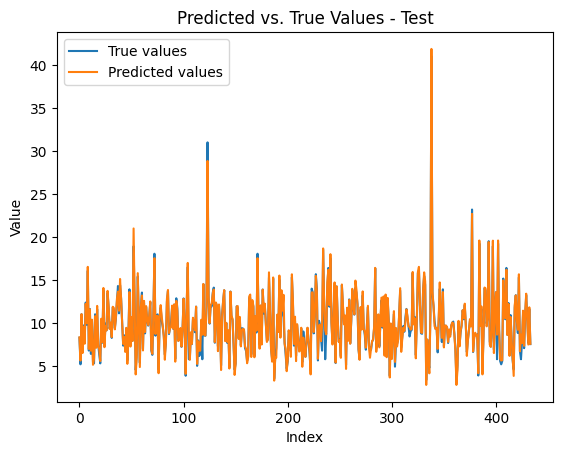

In [39]:
model.eval()

predicted_values = []
true_values = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.view(-1, 1, input_dim)
        outputs = model(data)
        predicted_values.extend(outputs.cpu().numpy())
        true_values.extend(labels.cpu().numpy())

plt.plot(true_values, label="True values")
plt.plot(predicted_values, label="Predicted values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Predicted vs. True Values - Test")
plt.legend()
plt.show()

In [44]:
model.eval()

with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data.view(-1, 1, input_dim))
        
        for i in range(len(outputs)):
            print("Test | Predikovaná hodnota:", outputs[i].item(), "| Skutočná hodnota:", labels[i].item())

Test | Predikovaná hodnota: 8.316595077514648 | Skutočná hodnota: 8.270000457763672
Test | Predikovaná hodnota: 5.618248462677002 | Skutočná hodnota: 5.179999828338623
Test | Predikovaná hodnota: 11.015623092651367 | Skutočná hodnota: 11.010000228881836
Test | Predikovaná hodnota: 6.4912638664245605 | Skutočná hodnota: 6.900000095367432
Test | Predikovaná hodnota: 9.568729400634766 | Skutočná hodnota: 9.699999809265137
Test | Predikovaná hodnota: 7.572345733642578 | Skutočná hodnota: 7.769999980926514
Test | Predikovaná hodnota: 12.209752082824707 | Skutočná hodnota: 12.359999656677246
Test | Predikovaná hodnota: 9.97061538696289 | Skutočná hodnota: 9.779999732971191
Test | Predikovaná hodnota: 16.513532638549805 | Skutočná hodnota: 16.059999465942383
Test | Predikovaná hodnota: 6.96269416809082 | Skutočná hodnota: 6.78000020980835
Test | Predikovaná hodnota: 11.565248489379883 | Skutočná hodnota: 11.619999885559082
Test | Predikovaná hodnota: 6.765223026275635 | Skutočná hodnota: 6.38

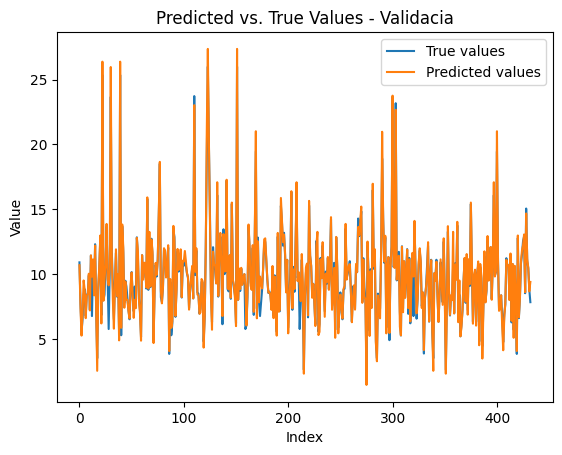

In [45]:
model.eval()

predicted_values = []
true_values = []

with torch.no_grad():
    for data, labels in validation_loader:
        data = data.view(-1, 1, input_dim)
        outputs = model(data)
        predicted_values.extend(outputs.cpu().numpy())
        true_values.extend(labels.cpu().numpy())

plt.plot(true_values, label="True values")
plt.plot(predicted_values, label="Predicted values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Predicted vs. True Values - Validacia")
plt.legend()
plt.show()

In [46]:
model.eval()

with torch.no_grad():
    for data, labels in validation_loader:
        outputs = model(data.view(-1, 1, input_dim))
        
        for i in range(len(outputs)):
            print("Validacia | Predikovaná hodnota:", outputs[i].item(), "| Skutočná hodnota:", labels[i].item())

Validacia | Predikovaná hodnota: 10.690204620361328 | Skutočná hodnota: 10.90999984741211
Validacia | Predikovaná hodnota: 7.410407066345215 | Skutočná hodnota: 7.789999961853027
Validacia | Predikovaná hodnota: 5.261014938354492 | Skutočná hodnota: 5.559999942779541
Validacia | Predikovaná hodnota: 6.978874683380127 | Skutočná hodnota: 6.570000171661377
Validacia | Predikovaná hodnota: 9.51419734954834 | Skutočná hodnota: 8.420000076293945
Validacia | Predikovaná hodnota: 8.803043365478516 | Skutočná hodnota: 8.84000015258789
Validacia | Predikovaná hodnota: 6.607211112976074 | Skutočná hodnota: 6.78000020980835
Validacia | Predikovaná hodnota: 8.373132705688477 | Skutočná hodnota: 8.369999885559082
Validacia | Predikovaná hodnota: 8.459345817565918 | Skutočná hodnota: 8.550000190734863
Validacia | Predikovaná hodnota: 10.033778190612793 | Skutočná hodnota: 9.899999618530273
Validacia | Predikovaná hodnota: 7.202847480773926 | Skutočná hodnota: 7.25
Validacia | Predikovaná hodnota: 11